<a href="https://colab.research.google.com/github/Alveuz/EquivalentImputation/blob/master/notebooks/ImputatorTester_alg_522.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
import pickle
from google.colab import data_table

with open('data_vars.pkl','rb') as f:  # Python 3: open(..., 'rb')
    na_ixes = pickle.load(f)
    gfd_all_df = pickle.load(f)
    gdf_norm = pickle.load(f)
    names_dict = pickle.load(f)

f = open('pp_vars.pkl', 'rb')
scaler = pickle.load(f)
f.close()

data_table.DataTable(gfd_all_df, include_index=True, num_rows_per_page=10)

,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Temperature
0,0.0246,288.6,35.50,9.000001,54.80,48.00,272.00,558.800001,140.0
1,0.0896,410.0,39.40,5.600001,26.00,65.00,392.60,595.400001,162.0
2,0.1200,680.0,70.00,6.100001,42.00,115.00,34.00,NaN,155.0
3,0.3800,230.0,7.40,0.100001,35.00,NaN,NaN,NaN,95.0
4,0.4200,506.0,55.00,4.900001,11.60,80.00,471.00,NaN,163.0
...,...,...,...,...,...,...,...,...,...
703,NaN,1275.0,140.00,0.240001,1.20,136.00,729.00,NaN,202.0
704,NaN,160.0,11.05,0.002001,1.62,130.17,43.50,NaN,169.0
705,NaN,160.0,12.25,0.003001,1.86,135.67,42.34,NaN,168.0
706,NaN,189.0,9.20,0.007001,2.08,124.00,70.30,NaN,178.0


# Quality Metric for CV

- The sum of the differences between the eigenvalues of original $\lambda_{original}$ data vs eigenvalues of the imputed data $\lambda_{imputed}$.
  
  The eigenvalues are pairwise matched by posing the problem as the linear sum assigment problem

In [ ]:
import numpy as np
import numpy.linalg
import pandas as pd

from numpy import linalg as LA

from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment

def cov_corr(df):
    cov = df.cov()
    corr = df.corr()
    cov_corr_df = pd.concat([cov, corr], axis=1)
    return cov_corr_df

def norm1_dist(df_corr_orig, df_corr_imputed):
  dist = np.linalg.norm(df_corr_orig-df_corr_imputed, ord = 1)
  return dist

def norm1_dist_per_ft(df_corr_orig, df_corr_imputed):
  nx, ny = df_corr_orig.shape
  tmp_names = df_corr_orig.columns
  zero_data = np.zeros(shape=(1,ny))
  dist = pd.DataFrame(zero_data, columns = tmp_names)
  
  for i in range(0, len(tmp_names)):
    dist.iloc[0,i] = np.linalg.norm(df_corr_orig.iloc[:,i]-df_corr_imputed.iloc[:,i], ord = 1)
  
  return dist

#The sum of the differences between the 
#eigenvalues of original data vs eigenvalues of the imputed data
#eigenvalues are pairwise matched by posing the problem as
#the linear sum assigment problem
def eigen_dist(df_corr_orig, df_corr_imputed):
  d,v = LA.eig(df_corr_orig)
  d2,v2 = LA.eig(df_corr_imputed)
  
  tmp_diff =  np.abs(d[:,np.newaxis] - d2)
  row_ind, col_ind = linear_sum_assignment(tmp_diff)
  
  # dist = tmp_diff[row_ind, col_ind].sum()
  # dist = np.max(np.abs(d[row_ind] - d2[col_ind]))
  dist = np.sum(np.abs(d[row_ind] - d2[col_ind]))
  # print(dist)
  return dist

# Training Utils

- Expand Grid for GridSearch

In [ ]:
import pandas as pd
import itertools

def expand_grid(tmp_ls):
  order = tmp_ls.keys()
  res = pd.DataFrame(itertools.product(*[tmp_ls[k] for k in order]), 
                     columns=order)
  return res

- GridSearch using the Eigenvalues Difference Distance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor

def GridSearchEigenDiff(tmp_data, estimator, param_list, cmplt_names, miss_var):
  best_params_ls = list()
  tmp_model = estimator
  
  prms_grd  = expand_grid(param_list)
  col_names = prms_grd.columns

  best_model = estimator
  best_params = prms_grd.iloc[0,:]
  best_distance = 100
  best_distance_perFt = tmp_data.iloc[0,:]
  best_imp_df = tmp_data.copy()
  best_imputer =  IterativeImputer(random_state= 0,
                                   max_iter=10, 
                                   estimator = tmp_model)

  for i in range(prms_grd.shape[0]):
    for j in range(len(col_names)):
      tmp_model = tmp_model.set_params(**{col_names[j]: prms_grd.iloc[i,j]})
    print(prms_grd.iloc[i,:])
    #impute_Missing_w_Full(tmp_data, [tmp_model], cmplt_names, miss_names)
    tmp_imp =  IterativeImputer(random_state= 0,
                                max_iter=10, 
                                estimator = tmp_model)
    
    X = tmp_data.copy()
    tmp_imp.fit(X)
    tmp_df = tmp_imp.transform(X)
    tmp_df = pd.DataFrame(tmp_df, columns= tmp_data.columns)

    # for miss_var in miss_names:
    #     # print(miss_var)
    #   X = tmp_data[np.append(cmplt_names, miss_var)].copy()
    #   tmp_imp.fit(X)
    #   tmp_df[miss_var] = tmp_imp.transform(X)[:,-1]

    corr_orig = tmp_data[names_dict['feat_names']].corr()
    corr_impu = tmp_df[names_dict['feat_names']].corr()
    eigen_d = eigen_dist(corr_orig,corr_impu)

    cc_orig = cov_corr(tmp_data[names_dict['feat_names']])
    cc_imp = cov_corr(tmp_df[names_dict['feat_names']])
    corv_dist = norm1_dist(cc_orig,cc_imp)
    corv_dist_perFt = norm1_dist_per_ft(cc_orig,cc_imp)
    
    # if best_distance>=corv_dist:
    if best_distance>=eigen_d:
      best_model = tmp_imp
      best_distance = eigen_d
      print(best_distance)
      best_params = prms_grd.iloc[i,:]
      best_distance_perFt = corv_dist_perFt
      best_imp_df = tmp_df.copy()
      best_imputer = tmp_imp

  best_params_ls.append(best_distance)
  best_params_ls.append(best_params)
  best_params_ls.append(best_distance_perFt)
  best_params_ls.append(best_imputer)
  best_params_ls.append(corv_dist)

  print(best_params, best_distance)
  print(best_distance_perFt)
  
  return best_model,best_imp_df,best_params_ls

# Model 5.2.2.

In [ ]:
from numpy import linalg as LA

mators_names = ['DT', 'SVR_l', 'SVR_r', 'RF']
mators_best_putators = list()
mators_best_params = list()
mators_imputed_data = list()

estimators =[
             DecisionTreeRegressor(random_state=0),
             SVR(kernel= 'linear', C=1.0, epsilon=0.3),
             SVR(kernel= 'rbf', C=1.0, epsilon=0.1,gamma='auto'),
             ExtraTreesRegressor(n_estimators=10, n_jobs=4, random_state=0)]

ExtraTreesRegressor(n_estimators=100, n_jobs=4, min_samples_split=25,
                    criterion= 'mae', min_samples_leaf=35, max_features=150)

params_ls = list()

dt_param_grid = {"criterion": ["mse", "mae"],
                "min_samples_split": np.arange(10,20, step =10),
                "max_depth": np.arange(2,6, step =1),
                "min_samples_leaf": np.arange(5,40, step =10),
                "max_leaf_nodes": np.arange(5,40, step =30)
                 }

svml_param_grid = {"C": [0.1,0.5,1],#np.arange(0.303,0.305, step =0.002),
          "epsilon": np.arange(0.25,0.4, step =0.01)}

svmr_param_grid = {"C": np.arange(0.1,10, step =0.05),#np.arange(9.63,9.65, step =0.05),
          "gamma": ['auto', 'scale'],
          "epsilon": np.arange(0.1,0.4, step =0.02)}

rf_param_grid = {"n_estimators": np.arange(4,20, step =1),
                #  "criterion":["mse", "mae"],
                #  "max_depth": np.arange(2,8, step =1),
                 'max_features':np.arange(2,6, step =1),
                 'min_samples_leaf':np.arange(20,31, step =10),
                #  'min_samples_split':np.arange(10,50, step =10),
          }

params_ls.append(dt_param_grid)
params_ls.append(svml_param_grid)
params_ls.append(svmr_param_grid)
params_ls.append(rf_param_grid)

for mator, ww in zip(estimators, range(0,len(estimators))):
  tmp_param_ls = params_ls[ww]
  tmp_model = mator
  tmp_data = gdf_norm.copy()
  # tmp_data = tmp_data.drop(labels='CBE', axis = 1)
  
  cmplt_names = ['Na','K','Temperature']
  miss_names = ['Li','Mg',"Ca", "Cl", "SO4", "HCO3"]

  imp_model,imp_data,mator_details = GridSearchEigenDiff(tmp_data, tmp_model, tmp_param_ls, 
                            cmplt_names, miss_names)
  
  mators_best_putators.append(imp_model)
  # imp_data['CBE'] = gdf_norm.CBE
  mators_imputed_data.append(imp_data.copy())
  mators_best_params.append(mator_details[1])

  print(mators_names[ww],mator_details[ww],mators_best_params[ww])

with open('alg522_imp_vars.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(mators_best_putators, f)
    pickle.dump(mators_imputed_data, f)
    pickle.dump(mators_best_params, f)

Se han truncado las últimas 5000 líneas del flujo de salida.
gamma      auto
epsilon     0.3
Name: 5226, dtype: object
C          8.25
gamma      auto
epsilon    0.32
Name: 5227, dtype: object
C          8.25
gamma      auto
epsilon    0.34
Name: 5228, dtype: object
C          8.25
gamma      auto
epsilon    0.36
Name: 5229, dtype: object
C          8.25
gamma      auto
epsilon    0.38
Name: 5230, dtype: object
C          8.25
gamma      auto
epsilon     0.4
Name: 5231, dtype: object
C           8.25
gamma      scale
epsilon      0.1
Name: 5232, dtype: object
C           8.25
gamma      scale
epsilon     0.12
Name: 5233, dtype: object
C           8.25
gamma      scale
epsilon     0.14
Name: 5234, dtype: object
C           8.25
gamma      scale
epsilon     0.16
Name: 5235, dtype: object
C           8.25
gamma      scale
epsilon     0.18
Name: 5236, dtype: object
C           8.25
gamma      scale
epsilon      0.2
Name: 5237, dtype: object
C           8.25
gamma      scale
epsilon     0.2

# Evaluation

### Original vs Imputed by DT

In [ ]:
tmp_df = mators_imputed_data[0]

corr_orig = gdf_norm[names_dict['feat_names']].corr()
corr_impu = tmp_df[names_dict['feat_names']].corr()

cc_orig = cov_corr(gdf_norm[names_dict['feat_names']])
cc_imp = cov_corr(tmp_df[names_dict['feat_names']])
# cc_imp = cov_corr(tmp_df[names_dict['feat_names']])
print('Frobenious:', norm1_dist(cc_orig,cc_imp))
print('EigenValues Difference:', eigen_dist(corr_orig,corr_impu))

norm1_dist_per_ft(cc_orig,cc_imp)

Frobenious: 0.861605766284399
EigenValues Difference: 0.8616715512568185


,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Li,Na,K,Mg,Ca,Cl,SO4,HCO3
0,0.03471,0.011913,0.011928,0.013673,0.019799,0.019188,0.011937,0.008993,0.861606,0.163306,0.196531,0.560906,0.434028,0.205852,0.274898,0.412676


### Original vs Imputed by $SVR_l$

In [ ]:
tmp_df = mators_imputed_data[1]

corr_orig = gdf_norm[names_dict['feat_names']].corr()
corr_impu = tmp_df[names_dict['feat_names']].corr()

cc_orig = cov_corr(gdf_norm[names_dict['feat_names']])
cc_imp = cov_corr(tmp_df[names_dict['feat_names']])

print('Frobenious:', norm1_dist(cc_orig,cc_imp))
print('EigenValues Difference:', eigen_dist(corr_orig,corr_impu))

norm1_dist_per_ft(cc_orig,cc_imp)

Frobenious: 2.083303899889809
EigenValues Difference: 0.7035432685257856


,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Li,Na,K,Mg,Ca,Cl,SO4,HCO3
0,0.039792,0.014864,0.018621,0.01374,0.017119,0.023051,0.017825,0.034095,0.705649,0.589978,0.584464,0.422818,0.545761,0.730099,0.549166,2.083304


### Original vs Imputed by $SVR_r$

In [ ]:
tmp_df = mators_imputed_data[2]

corr_orig = gdf_norm[names_dict['feat_names']].corr()
corr_impu = tmp_df[names_dict['feat_names']].corr()

cc_orig = cov_corr(gdf_norm[names_dict['feat_names']])
cc_imp = cov_corr(tmp_df[names_dict['feat_names']])

print('Frobenious:', norm1_dist(cc_orig,cc_imp))
print('EigenValues Difference:', eigen_dist(corr_orig,corr_impu))

norm1_dist_per_ft(cc_orig,cc_imp)

Frobenious: 1.7314714201825625
EigenValues Difference: 1.2914102868318518


,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Li,Na,K,Mg,Ca,Cl,SO4,HCO3
0,0.028367,0.009059,0.009215,0.012645,0.011031,0.012456,0.013268,0.012318,1.731471,0.623017,0.600947,0.487654,0.419791,0.713298,0.356463,0.553766


### Original vs Imputed by **RF**

In [ ]:
tmp_df = mators_imputed_data[3]

corr_orig = gdf_norm[names_dict['feat_names']].corr()
corr_impu = tmp_df[names_dict['feat_names']].corr()

cc_orig = cov_corr(gdf_norm[names_dict['feat_names']])
cc_imp = cov_corr(tmp_df[names_dict['feat_names']])

print('Frobenious:', norm1_dist(cc_orig,cc_imp))
print('EigenValues Difference:', eigen_dist(corr_orig,corr_impu))

norm1_dist_per_ft(cc_orig,cc_imp)

Frobenious: 0.5810213021063981
EigenValues Difference: 0.6391111038083058


,Li,Na,K,Mg,Ca,Cl,SO4,HCO3,Li,Na,K,Mg,Ca,Cl,SO4,HCO3
0,0.021999,0.008285,0.008875,0.011054,0.011917,0.015525,0.015492,0.009742,0.581021,0.189787,0.216749,0.45634,0.219453,0.148345,0.262779,0.404243


## Viz

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

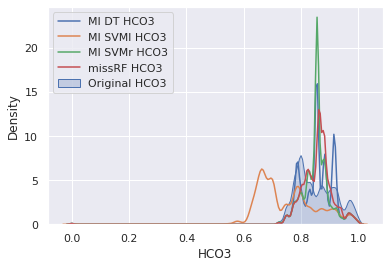

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

adt_df = mators_imputed_data[0]
asvml_df = mators_imputed_data[1]
asvmr_df = mators_imputed_data[2]
arf_df = mators_imputed_data[3]

# sns.distplot(gdf_norm.Li);
# sns.distplot(imp.data.Li);

sns.kdeplot(adt_df.HCO3, bw=0.1, label="MI DT HCO3")
sns.kdeplot(asvml_df.HCO3, bw=0.1, label="MI SVMl HCO3")
sns.kdeplot(asvmr_df.HCO3, bw=0.1, label="MI SVMr HCO3")
sns.kdeplot(arf_df.HCO3, bw=0.1, label="missRF HCO3")
sns.kdeplot(gdf_norm.HCO3, bw = 0.1, label="Original HCO3", shade=True)
plt.legend()